In [9]:
%cd drive/MyDrive/RETINAL

/content/drive/MyDrive/RETINAL


In [11]:
!ls

augment.ipynb  models	test	  training	unet-2.ipynb
files	       outputs	test.zip  training.zip	unet.ipynb


# DataLoader

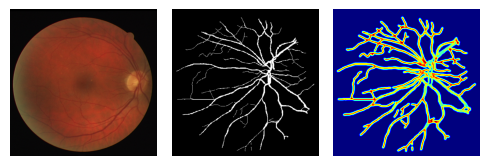

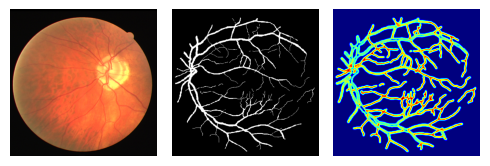

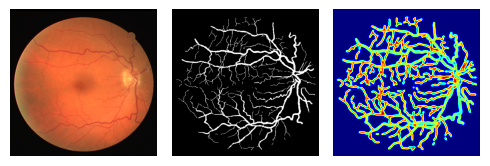

In [24]:
import os
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import numpy as np
from PIL import Image
from skimage import feature
from skimage.filters import gaussian
from skimage.morphology import binary_dilation


class DRIVEDataset(Dataset):
    """DRIVE dataset."""

    def __init__(self, image_files, label_files, transform=None):
        """

        :param image_files:
        :param label_files:
        :param transform:
        """
        self.image_files = image_files
        self.label_files = label_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        seg_name = self.label_files[idx]

        image = Image.open(img_name)
        label = Image.open(seg_name)

        sample = {"img": image, "seg": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


class WeightMap(object):
    """
    Compute weight map for the label
    """

    def __call__(self, sample):
        """

        :param sample:
        :return:
        """
        label = sample["seg"]
        weight_map = feature.canny(label)
        weight_map = binary_dilation(weight_map)
        weight_map = gaussian(weight_map, sigma=2)
        weight_map  = weight_map * 3 + 1
        sample["map"] = weight_map
        return sample


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["img"], sample["seg"]

        w, h = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = image.resize((new_h, new_w), resample=2)
        label = label.resize((new_h, new_w), resample=0)

        return {"img": image, "seg": label}


class Normalize(object):
    """
    Normalize the image and label
    """
    def __call__(self, sample):

        image, label = sample["img"], sample["seg"]

        image, label = np.array(image), np.array(label)

        image = image.astype(np.float32) / 255.
        label = label.astype(int) / 255.

        return {"img": image, "seg": label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, weight = sample["img"], sample["seg"], sample["map"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {
            "img": torch.from_numpy(image),
            "seg": torch.from_numpy(label),
            "map": torch.from_numpy(weight),
        }



IMAGE_ROOT = "./training/images"
LABEL_ROOT = "./training/1st_manual"

images = glob(os.path.join(IMAGE_ROOT, "*training.tif"))
labels = glob(os.path.join(LABEL_ROOT, "*manual1.gif"))

data_transform = transforms.Compose([
    Rescale((512, 512)),
    Normalize(),
    WeightMap(),
    ToTensor(),
])

train_ds = DRIVEDataset(images[:-10], labels[:-10], transform=data_transform)
valid_ds = DRIVEDataset(images[-10:], labels[-10:], transform=data_transform)

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=True, num_workers=0, pin_memory=True,
)

val_loader = DataLoader(
    valid_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=True,
)




import matplotlib.pyplot as plt

for idx, batch in enumerate(train_loader):

    image, label, weight = batch["img"], batch["seg"], batch["map"]
    image, label, weight = image.numpy(), label.numpy(), weight.numpy()

    assert list(np.unique(label)) == [0, 1]

    for img, lbl, wgt in zip(image, label, weight):
        fig, ax = plt.subplots(1, 3, figsize=(5, 2))
        ax[0].imshow(img.transpose(1, 2, 0))
        ax[1].imshow(lbl, cmap="gray")
        ax[2].imshow(wgt, cmap="jet")
        [a.set_axis_off() for a in ax]
        plt.tight_layout()
        plt.show()

        break


# Train

In [42]:
%pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [43]:
import os
import sys
from glob import glob
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.visualize import plot_2d_or_3d_image


monai.config.print_config()


MONAI version: 1.3.2
Numpy version: 1.25.2
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.42.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

In [ ]:
# create UNet and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = F.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)

In [ ]:

# start a typical PyTorch training
epochs_total = 1000
val_interval = 1
best_loss = np.inf
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(epochs_total):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs_total}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels, weights = (
            batch_data["img"].to(device),
            batch_data["seg"].to(device),
            batch_data["map"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            epoch_val_loss = []
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels, val_weights = (
                    val_data["img"].to(device),
                    val_data["seg"].to(device),
                    val_data["map"].to(device),
                )
                val_outputs = model(val_images).squeeze()
                loss = loss_function(val_outputs, val_labels)
                epoch_val_loss.append(loss.item())
            epoch_val_loss = np.array(epoch_val_loss).mean()
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(), "best_metric_model_segmentation2d_dict.pth"
                )
                print("saved new best metric model")
            print(
                "current epoch: {} current val loss: {:.4f} best val loss: {:.4f} at epoch {}".format(
                    epoch + 1, epoch_val_loss, best_loss, best_metric_epoch
                )
            )
            writer.add_scalar("val_loss", epoch_val_loss, epoch + 1)
            # plot the last model output as GIF image in TensorBoard with the corresponding image and label
            plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(
                val_outputs, epoch + 1, writer, index=0, tag="output"
            )

print(f"train completed, best_loss: {best_loss:.4f} at epoch: {best_metric_epoch}")
writer.close()
